<a href="https://colab.research.google.com/github/jimjoseph51000/fpl-simulator/blob/main/simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
% cd /gdrive/MyDrive/CSE_519_DSF/gitcode/fpl_simulator_main_reward_function/

/gdrive/MyDrive/CSE_519_DSF/gitcode/fpl_simulator_main_reward_function


In [3]:
! pwd

/gdrive/MyDrive/CSE_519_DSF/gitcode/fpl_simulator_main_reward_function


In [4]:
% ls

'CSE_519_DSF_Proposal___Fantasy_Premier_League (1).pdf'
'CSE_519___FPL_Progress_Report (1).pdf'
 FillBetween3d.py
 fpl_mc_train.log
 LICENSE
 logs/
 model.py
 models/
 model_sanity_checks.ipynb
 Player_Cost_Weekwise/
'Player Embedding.ipynb'
'Player Profiles.ipynb'
 Player_Rankings/
 Players_Weekwise/
 player_types.csv
 plots/
'Progress Report'/
 __pycache__/
 README.md
 readme_plot.png
'Sanity Checker.ipynb'
 scout.py
 simulator.py
 simulator_reward_bottom.ipynb
 simulator_reward_evaluation_plots.ipynb
 simulator_reward_random.ipynb
 simulator_reward_top.ipynb
 temp_data/
 train0.log.gdoc


In [5]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from simulator import *
from model import *
from scout import * 
# from util import *

In [6]:

import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

import datetime
import copy

def random_action():
  idx = np.random.randint(N_actions)
  return possible_actions[idx], idx

def epsilon_greedy_action(env, state, model, epsilon, t):

  state = np.array(state) # (N_states,)
  assert(state.shape == (620,))
  assert(state.ndim == 1)
  # bp()
  week_vector = np.zeros(current_week)
  week_vector[t] = 1.0
  state = np.append(state, week_vector) # (630,)
  # we are gonna evaluate over all the different set of actions
  # print(possible_actions.shape) # (5,11)
  input = np.hstack((np.broadcast_to(state,(possible_actions.shape[0], state.shape[0])), possible_actions)) # (N_A,N_S+N_A)
  # print(input.shape)
  assert(input.shape == (N_actions, possible_actions.shape[1] + N_states + current_week)) # we are adding in the week vector too for now

  X = torch.from_numpy(input).float().cuda()
  model.eval()
  Y = model(X)
  assert(Y.shape == (N_actions,1))
  Y = Y.detach().cpu().numpy()
  best_idx = np.argmax(Y.reshape(-1))

  # you dont get to choose the best action. have soft probabilities based on exploration epsilon
  selection_prob_arr = np.zeros(N_actions, dtype=np.float)
  selection_prob_arr[:] = epsilon / N_actions
  selection_prob_arr[best_idx] = (epsilon / N_actions) + (1 - epsilon)
  # bp()
  assert(selection_prob_arr.sum().round() == 1.0)
  idx = np.random.choice(N_actions,1,replace=False, p = selection_prob_arr)
  # assert(idx.shape == (1,))
  model.train()
  # bp()
  # env.action_space.sample()
  return possible_actions[idx[0]], idx[0]

def calculate_episode_return(episode, gamma):
  episode = np.array(episode)
  assert(episode.ndim == 2)
  assert(episode.shape[0] == current_week)
  states_array = episode[:,0]
  # actions_array = episode[:,1]
  rewards_array = episode[:,2]
  # gamma_array = [gamma**i for i in range(episode.shape[0])]
  # Gt = rt + gamma * Gt\+1.
  # bp()
  G = np.array([0 for i in range(states_array.shape[0])], dtype = np.float)
  for i in range(G.shape[0]-1,-1,-1):
    # temp = G[i+1]
    if i == G.shape[0] - 1:
      temp = 0
    else:
      temp = G[i+1]
    G[i] = rewards_array[i] + gamma * temp
  # bp()
  # print(G)
  # assert(G[-1] == 1.0)
  return G


def update_Q_value(G, episode, model, optimizer):
  episode = np.array(episode)
  model = model.cuda()
  model.train()
  optimizer.zero_grad()
  loss_criterion = nn.MSELoss()
  # bp()
  action_arr = possible_actions[np.array(episode[:,1], np.int),:] #(num_weeks,N_actions)
  state_arr = np.array([i.tolist() for i in episode[:,0]], np.float) #(num_weeks,N_states)
 
  assert(state_arr.shape[0] == action_arr.shape[0])
  week_vector = np.eye(current_week) # (num_weeks,num_weeks)
  # print('update',state_arr.shape, week_vector.shape)
  state_arr = np.hstack((state_arr, week_vector)) # (num_weeks, N_states + num_weeks)
  X = torch.from_numpy(np.hstack((state_arr, action_arr))).cuda().float() #(num_weeks, N_states + num_weeks + N_actions) 
  # print(X.shape)
  Y = torch.from_numpy(G[:,np.newaxis]).float().cuda() # (B,1)
  # old_mean = Y.mean()
  # old_std = Y.std()
  # Y = (Y - old_mean) / old_std 
  # bp()
  output = model(X)
  # print('output {}, Y {}'.format(output.mean(),Y.mean()))
  assert(output.shape == Y.shape)
  loss = loss_criterion(output,Y)
  loss.backward()
  optimizer.step()
  assert(loss.grad_fn != None)
  model.eval()
  return loss.detach().cpu().numpy(), output.detach().cpu().numpy(), Y.detach().cpu().numpy()

### Logging setup

In [7]:
from datetime import datetime
import logging

# logger = logging.getLogger()
# fhandler = logging.FileHandler(filename='./logs/fpl_mc_train0.log', mode='a')
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fhandler.setFormatter(formatter)
# logger.addHandler(fhandler)
# logger.setLevel(logging.DEBUG)



### Evaluation

In [8]:
logging.basicConfig(filename='./logs/eval_fpl_mc_train.log', level=logging.INFO)

'''
  Declaring all the variables here
'''

fpl_manager_data = {'2757':0, '4424129':0, '2963971':15,'3720286':0,'799571':0} ; key_word = '';# top 
# fpl_manager_data = {'492':0,'494':5,'495':0,'498':0,'499':0}; key_word = 'random_'; # random
# fpl_manager_data = {'992':5,'993':0,'994':0,'995':0,'1000':0} ; key_word = 'bottom_';# bottom

save_path = './models/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
print('save path :{}'.format(save_path))

projs = []
mgrs_points = []

for fpl_manager_id, balance in fpl_manager_data.items():

  epsilon = 0.1
  gamma = 1.0
  current_week = 10
  n_episode = 10000     # number of episodes
  max_steps = 1000  # maximum steps for each episode
  lr = 1e-3
  epsilon_iter_delta = 200 # this needs to be high . need more exploration 
  min_balance = 10
  file_name = key_word+'recruiter_mgr_id_{}'.format(fpl_manager_id)
  N_actions = len(profiles)
  N_states = 620


  model_saved_path = os.path.join(save_path,file_name+'.pth')
  K = 15

  params = {'current_week' : current_week,
          'fpl_manager_id' : fpl_manager_id, 
          'balance':balance,
          'min_balance':min_balance,
          'K':K,
          'profiles':profiles,
          'epsilon' :epsilon,
          'gamma' : gamma,
          }
  # logging.basicConfig(filename='./logs/eval_fpl_mc_train.log', level=logging.INFO)

  logging.info("Params : {}".format(params))
  print("Params : {}".format(params))

  checkpoint = torch.load(model_saved_path)
  # network_eval = InvPendNet(4,2)
  possible_actions = np.array([d['prob_dist'] for d in profiles])

  network_eval = RecruiterNetwork(N_states + current_week, possible_actions.shape[1])
  network_eval.load_state_dict(checkpoint)
  network_eval.eval()
  network_eval.cuda()

  env = FPLSimulator(current_week, fpl_manager_id, req_cols=['stats.ict_index','element_type'], balance = balance)

  

  observation = env.reset()
  episode = []
  G_all = []
  # optimizer = optim.Adam(network.parameters(), lr=lr)

  for t in range(current_week):
    scout = Scout(env, t, min_balance, env.balance, K)

    s = observation
    a, action_idx = epsilon_greedy_action(env, s, network_eval, epsilon, t)
    # a, action_idx = random_action() 
    observation, r, done = env.step(action_idx, t, scout)
    # s_prime = observation
    episode.append([s,action_idx,r])
    # print('episode {}, game week {}'.format(i_episode, t))
    if done:
      break
  # more_episodes = generate_episodes(env, episode)

  G_all = calculate_episode_return(episode,gamma)
  # loss,out,gt = update_Q_value(G_all, episode, network_eval, optimizer)

  logging.info(' ::::: Evaluation ::::')

  # logging.info('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), 0 , epsilon, G_all[0], out.mean(), gt.mean(), loss))
  # print('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), 0 , epsilon, G_all[0], out.mean(), gt.mean(), loss))

  proj = np.array(env.transfers_in_episode).sum(axis=1)
  # env.sample_visualization(1,[proj], file_save = './plots/'+file_name+'.png')
  new_team_player_ids, new_team_player_points, new_team_player_cost  = env.do_transfer(proj, env.actual_players_ids)

  projs.append(proj)
  

  actual_points_per_week = env.actual_players_points.sum(axis=0)
  new_points_per_week = new_team_player_points.sum(axis=0)

  mgrs_points.append([actual_points_per_week, new_points_per_week])


save path :./models/
Params : {'current_week': 10, 'fpl_manager_id': '2757', 'balance': 0, 'min_balance': 10, 'K': 15, 'profiles': [{'cols': ['stats.minutes'], 'order': [False], 'prob_dist': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, {'cols': ['stats.own_goals', 'stats.yellow_cards', 'stats.red_cards'], 'order': [True, True, True], 'prob_dist': [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]}, {'cols': ['stats.ict_index'], 'order': [False], 'prob_dist': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'cols': ['selected_by_percent'], 'order': [False], 'prob_dist': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]}, {'cols': ['saves_goal_conceded_ratio', 'stats.saves', 'stats.clean_sheets', 'stats.penalties_saved', 'stats.penalties_missed'], 'order': [False, False, False, False, True], 'prob_dist': [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]}], 'epsilon': 0.1, 'gamma': 1.0}
(620,) (620, 10) (620, 10) (2, 620, 10)
cumsum of per_week_total_points:  [ 80. 166. 238. 297. 355. 401. 436. 484. 540. 588.]
(15, 10) (15, 10) (15, 10) (2, 15, 10)
Params :

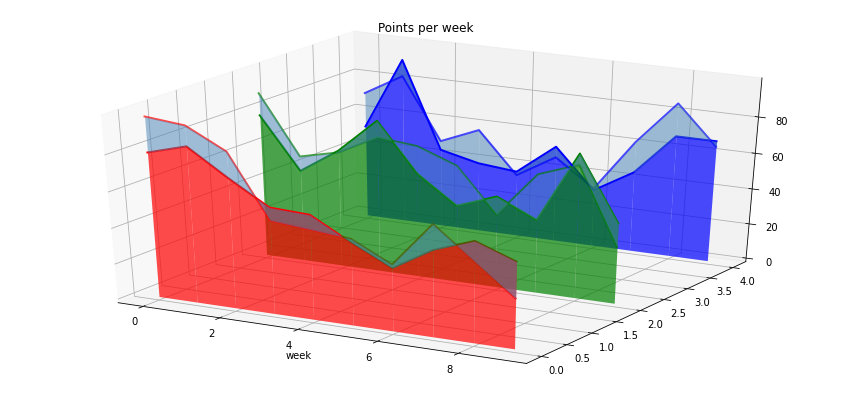

In [116]:

from mpl_toolkits import mplot3d
plt.figure(figsize=(15,7))
colors = ['r','g','b','c','m']
ax = plt.axes(projection='3d')

ax.tick_params(left = True, right = False , labelleft = True , labelright=False,
                labelbottom = True, bottom = True)

plt.title('Points per week')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection # New import

from FillBetween3d import *

alpha = 0.6
for i, (fpl_manager_id, balance) in enumerate(fpl_manager_data.items()):
  # mgr_id = fpl_manager_data[i]
  actual_points_per_week = mgrs_points[i][0]
  new_points_per_week =  mgrs_points[i][1]
  actual_points_cumsum = np.cumsum(actual_points_per_week)
  new_points_cumsum = np.cumsum(new_points_per_week)

  j = i * 2
  set01 = [x, j*np.ones(len(x)), np.zeros(len(x))]
  set1  = [x, j*np.ones(len(x)), actual_points_per_week]
  ax.plot(*set1, lw=2, zorder=20, c=colors[i])
  fill_between_3d(ax, *set01, *set1, mode = 1, c=colors[i], alpha = 0.7)


  set02 = [x, j*np.ones(len(x)), np.zeros(len(x))]
  set2  = [x, j*np.ones(len(x)), new_points_per_week]
  ax.plot(*set2, lw=2, zorder=20, c=colors[i] , alpha = 0.7)
  # fill_between_3d(ax, *set02, *set2, mode = 1, c='b', alpha = 0.2)

  fill_between_3d(ax, *set1, *set2, mode = 1, alpha = 0.5)
  plt.xlabel('week')
  # plt.ylabel('mgr_id')

  # ax.text()
  if i == 2:
    break


# ax.set_yticklabels(list(fpl_manager_data.keys()))
ax.set_zlim((0,np.max(np.array(mgrs_points))))

# plt.legend(list(fpl_manager_data.keys()))
plt.show()

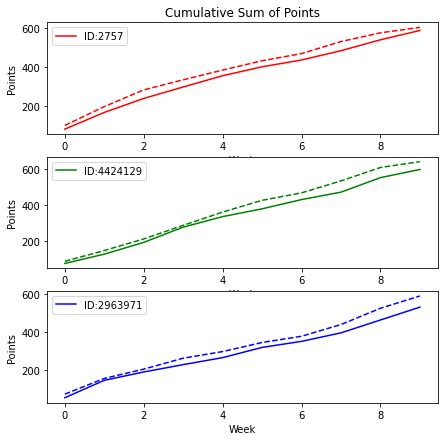

In [117]:

from mpl_toolkits import mplot3d

colors = ['r','g','b','c','m']
# ax = plt.axes(projection='3d')


# plt.title('Points per week')
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection # New import

# from FillBetween3d import *

alpha = 0.6
fig = plt.figure(figsize=(7,7))
for i, (fpl_manager_id, balance) in enumerate(fpl_manager_data.items()):
  # mgr_id = fpl_manager_data[i]
  
  plt.subplot(3,1,i+1)
  actual_points_per_week = mgrs_points[i][0]
  new_points_per_week =  mgrs_points[i][1]
  actual_points_cumsum = np.cumsum(actual_points_per_week)
  new_points_cumsum = np.cumsum(new_points_per_week)


  plt.plot(actual_points_cumsum, colors[i]+'-' , label = 'ID:'+fpl_manager_id)
  plt.plot(new_points_cumsum, colors[i]+'--')
  # ax.text()
  if i == 0 :
    plt.title('Cumulative Sum of Points')
  plt.xlabel('Week')
  plt.ylabel('Points')
  plt.legend()
  if i == 2:
    break

  
  # plt.legend(list(fpl_manager_data.keys()))
# fig.savefig(os.path.join('./plots/','bottom_5_cumsum.png'), dpi=300, bbox_inches='tight')
# model_saved_path = os.path.join(save_path,file_name+'.pth')

plt.show()

In [9]:
fpl_manager_data[0]

KeyError: ignored

In [ ]:
[e[1] for e in episode]

In [ ]:
env.actual_players_ids

In [ ]:
proj.sum(axis=0)

In [ ]:
env.running_player_ids

In [ ]:
original_cum_points = np.cumsum(env.actual_players_points.sum(axis=0))
new_cum_points = np.cumsum(env.running_player_points.sum(axis=0))
original_cum_points , new_cum_points